<a href="https://colab.research.google.com/github/therohim/repo-ai/blob/master/food-101/AI_Food_101_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Recognition(food101🍕) with ***Transfer learning*** using `Tensorflow`

#### *food101* is a famous dataset for image recognition, in this notebook I want to use a limited version of it with just 10 classes.

### but what is transfer learning?
> accoarding to wikipedia
Transfer learning (TL) is a research problem in machine learning (ML) that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem. For example, knowledge gained while learning to recognize cars could apply when trying to recognize trucks.

![](https://datascience.aero/wp-content/uploads/2020/03/transferlearning-119.jpg)

### in this problem, using others proven model in the same topic can be really helpful.
#### tensorflow gives us the power of transfer learning simply!

#### import libraries📚:
* tensorflow - deep learning modelling
* numpy - numperical computing
* pandas - working with dataframes
* matplotlib - plotting curves

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## download the data(in zip format) and extract to use it.(to do that we first need to import zipfile)
### source🔗: https://github.com/mrdbourke/tensorflow-deep-learning

In [ ]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

zip_file = zipfile.ZipFile("10_food_classes_all_data.zip")
zip_file.extractall()
zip_file.close()

--2025-02-02 14:53:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.207, 74.125.197.207, 142.251.188.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M   225MB/s    in 2.2s    

2025-02-02 14:53:54 (225 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



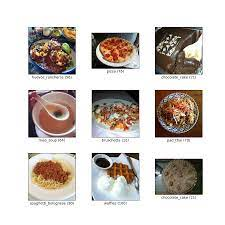

### creating variables that contain train and test directories paths📖

In [ ]:
train_dir = "./10_food_classes_all_data/train"
test_dir = "./10_food_classes_all_data/test"

### walking through all directories and files🚶‍♀️

In [ ]:
import os
for path, dir_name, file_name in os.walk('./10_food_classes_all_data/'):
    print("in {}, there are(is) {} directories(directory) and {} files".format(path, len(dir_name), len(file_name)))

in ./10_food_classes_all_data/, there are(is) 2 directories(directory) and 0 files
in ./10_food_classes_all_data/train, there are(is) 10 directories(directory) and 0 files
in ./10_food_classes_all_data/train/ramen, there are(is) 0 directories(directory) and 750 files
in ./10_food_classes_all_data/train/pizza, there are(is) 0 directories(directory) and 750 files
in ./10_food_classes_all_data/train/sushi, there are(is) 0 directories(directory) and 750 files
in ./10_food_classes_all_data/train/steak, there are(is) 0 directories(directory) and 750 files
in ./10_food_classes_all_data/train/grilled_salmon, there are(is) 0 directories(directory) and 750 files
in ./10_food_classes_all_data/train/hamburger, there are(is) 0 directories(directory) and 750 files
in ./10_food_classes_all_data/train/chicken_curry, there are(is) 0 directories(directory) and 750 files
in ./10_food_classes_all_data/train/fried_rice, there are(is) 0 directories(directory) and 750 files
in ./10_food_classes_all_data/trai

#### ignore warnings ⚠

In [ ]:
import warnings

warnings.filterwarnings('ignore')

## really important step! preprocessing images!📷
***first we create ImageDataGenerator, for data augmentation, we add some arguments.***

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_img_gen = ImageDataGenerator(
    height_shift_range=0.2,
    width_shift_range=0.2,
    rotation_range=0.15,
    horizontal_flip=True,
    shear_range=0.1,
    zoom_range=0.25
)

test_img_gen = ImageDataGenerator(
    height_shift_range=0.2,
    width_shift_range=0.2,
    rotation_range=0.15,
    horizontal_flip=True,
    shear_range=0.1,
    zoom_range=0.25
)

### flow_from_directory -> for final step we apply our data augmentation to images and create train_data, test_data⚡

In [ ]:
train_data = train_img_gen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=101
)

test_data = test_img_gen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=101
)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


### Extracting food classes 🍕

In [ ]:
class_names = os.listdir(train_dir)
class_names

['ramen',
 'pizza',
 'sushi',
 'steak',
 'grilled_salmon',
 'hamburger',
 'chicken_curry',
 'fried_rice',
 'ice_cream',
 'chicken_wings']

### Plotting random images and class names 📷

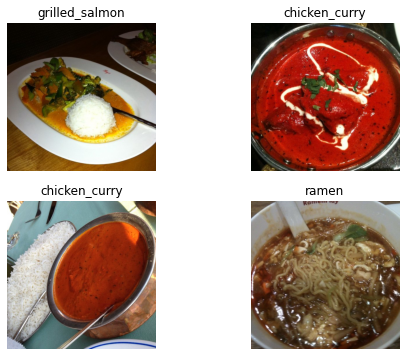

In [ ]:
import random
import matplotlib.image as mpimg

plt.figure(figsize=(8, 6))

for i in range(0, 4):
    class_name = random.choice(os.listdir(train_dir))
    random_path = random.choice(os.listdir(train_dir + '/' + class_name))
    img_path = train_dir + '/' + class_name + '/' + random_path
    ax = plt.subplot(2, 2, i+1)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

# Building Models🛠
### we need to train a feature extraction model, for 5 epochs, then we make some base model layers untrainable,to apply fine tuning
1. first, we create base_model
2. we make it untrainable
3. define input shape
4. adding input layer to base model
5. GlobalAveragePooling to outputting feature vector
6. final step! tf.keras.Model(input, output)

In [ ]:
base_model = tf.keras.applications.EfficientNetB1(include_top=False)
base_model.trainable = False
input_layer = tf.keras.layers.Input(shape=(224, 224, 3))
x = base_model(input_layer)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output_layer = tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)(x)
model = tf.keras.Model(input_layer, output_layer)

## Compile the model
1. Adam optimizer, wise decision!
2. categorical_crossentropy, we have one-hot encoded results
3. accuracy metric, same as always

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

### callbacks:
> Tensorflow callbacks are functions or blocks of code which are executed during a specific instant while training a Deep Learning Model. ... In the usual workflow before training the model, we fix all the options and parameters like learning rate, optimizers, losses. etc and start the model training.

source -> https://www.analyticsvidhya.com/blog/2021/08/quick-start-with-tensorflow-callbacks/#:~:text=Tensorflow%20callbacks%20are%20functions%20or,training%20a%20Deep%20Learning%20Model.&text=In%20the%20usual%20workflow%20before,and%20start%20the%20model%20training.

In [ ]:
check_point_callback = tf.keras.callbacks.ModelCheckpoint(filepath='modelcheckpoint/checkpoint.ckpt')
tensorboard_callback = tf.keras.callbacks.TensorBoard("tensorboard/")

#### ***we are not going to use these callback, just to mention them!***

## Fitting the model, 5 epochs, with steps equal to training and testing batches🛠

In [ ]:
history_1 = model.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data)
)

Epoch 1/5
235/235 [==============================] - 382s 2s/step - loss: 1.0210 - accuracy: 0.6937 - val_loss: 0.5526 - val_accuracy: 0.8408
Epoch 2/5
235/235 [==============================] - 371s 2s/step - loss: 0.6176 - accuracy: 0.8085 - val_loss: 0.4668 - val_accuracy: 0.8652
Epoch 3/5
235/235 [==============================] - 370s 2s/step - loss: 0.5500 - accuracy: 0.8227 - val_loss: 0.4239 - val_accuracy: 0.8724
Epoch 4/5
235/235 [==============================] - 367s 2s/step - loss: 0.5163 - accuracy: 0.8336 - val_loss: 0.4004 - val_accuracy: 0.8760
Epoch 5/5
235/235 [==============================] - 368s 2s/step - loss: 0.4805 - accuracy: 0.8471 - val_loss: 0.3957 - val_accuracy: 0.8812


### evaluate the model🔍

In [ ]:
model.evaluate(test_data)

79/79 [==============================] - 90s 1s/step - loss: 0.3940 - accuracy: 0.8780


[0.3940459191799164, 0.878000020980835]

In [ ]:
feature_extraction_results = pd.DataFrame(history_1.history)
feature_extraction_results

,loss,accuracy,val_loss,val_accuracy
0,1.021003,0.693733,0.552565,0.8408
1,0.617611,0.808533,0.466780,0.8652
2,0.550048,0.822667,0.423935,0.8724
3,0.516269,0.833600,0.400449,0.8760
4,0.480549,0.847067,0.395733,0.8812


### plotting curves📉

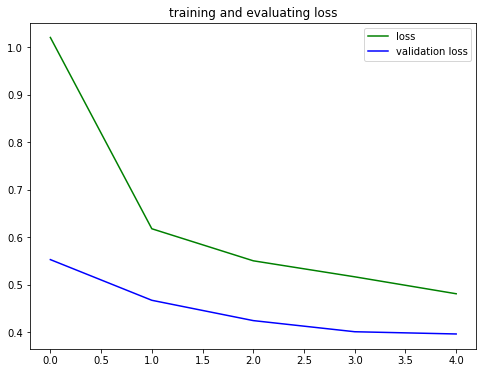

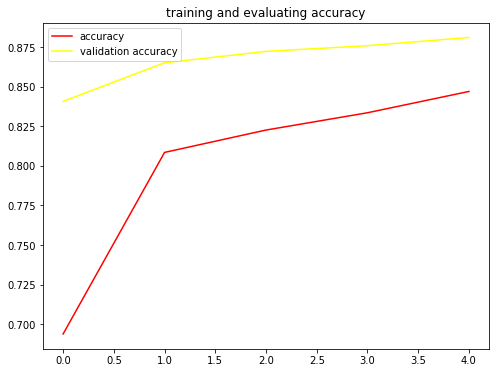

In [ ]:
def plot_accuracy_loss_curves(history):
    plt.figure(figsize=(8, 6))
    plt.title('training and evaluating loss')
    plt.plot(feature_extraction_results['loss'], label='loss', c='green')
    plt.plot(feature_extraction_results['val_loss'], label='validation loss', c='blue')
    plt.legend();

    plt.figure(figsize=(8, 6))
    plt.title('training and evaluating accuracy')
    plt.plot(feature_extraction_results['accuracy'], label='accuracy', c='red')
    plt.plot(feature_extraction_results['val_accuracy'], label='validation accuracy', c='yellow')
    plt.legend();

plot_accuracy_loss_curves(history_1)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb1 (Functional)  (None, None, None, 1280)  6575239   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                12810     
Total params: 6,588,049
Trainable params: 12,810
Non-trainable params: 6,575,239
_________________________________________________________________


### plotting the model

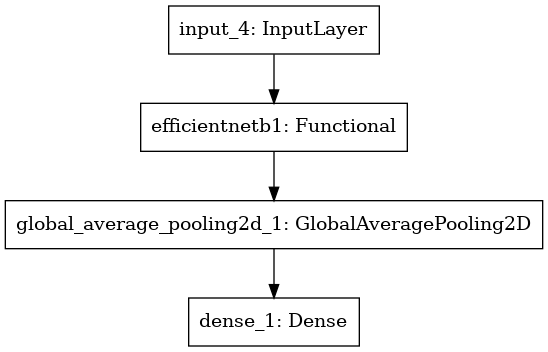

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model)

### see the model and base model layers

In [ ]:
for layer in model.layers:
    print(layer)

In [ ]:
base_model.layers[:10]

### making last 10 layers trainable to create a simple fine-tuning model

In [ ]:
base_model.trainable = True

for layer_num, layer in enumerate(base_model.layers[:-10]):
    layer.trainable = False

#### we can see all trainable layers with another for loop

In [ ]:
for layer_num, layer in enumerate(model.layers):
    print(layer_num, layer.name, layer.trainable)

0 input_4 True
1 efficientnetb1 True
2 global_average_pooling2d_1 True
3 dense_1 True


### We need to recompile the model after changing it for fine-tuning

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

### Fit another time!

In [ ]:
fine_tuning_history = model.fit(
    train_data,
    epochs=10,
    validation_data=test_data,
    validation_steps=len(test_data),
    initial_epoch=5
)

Epoch 6/10
235/235 [==============================] - 396s 2s/step - loss: 0.2940 - accuracy: 0.9084 - val_loss: 0.3186 - val_accuracy: 0.8968
Epoch 7/10
235/235 [==============================] - 387s 2s/step - loss: 0.2726 - accuracy: 0.9164 - val_loss: 0.2931 - val_accuracy: 0.8992
Epoch 8/10
235/235 [==============================] - 385s 2s/step - loss: 0.2480 - accuracy: 0.9252 - val_loss: 0.3117 - val_accuracy: 0.8964
Epoch 9/10
235/235 [==============================] - 387s 2s/step - loss: 0.2308 - accuracy: 0.9273 - val_loss: 0.3069 - val_accuracy: 0.9004
Epoch 10/10
235/235 [==============================] - 388s 2s/step - loss: 0.2222 - accuracy: 0.9325 - val_loss: 0.2906 - val_accuracy: 0.9092


## Final Evaluating📊

In [ ]:
fine_tuning_history_df = pd.DataFrame(fine_tuning_history.history)
fine_tuning_history_df

,loss,accuracy,val_loss,val_accuracy
0,0.294011,0.908400,0.318553,0.8968
1,0.272568,0.916400,0.293066,0.8992
2,0.247957,0.925200,0.311747,0.8964
3,0.230771,0.927333,0.306897,0.9004
4,0.222243,0.932533,0.290638,0.9092


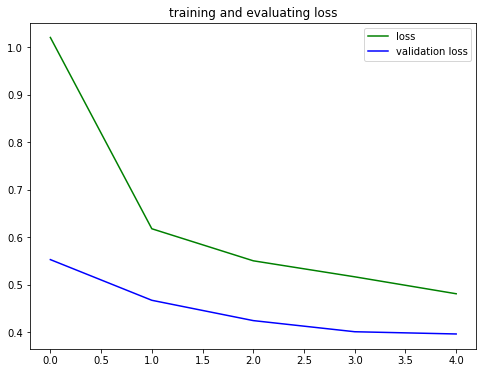

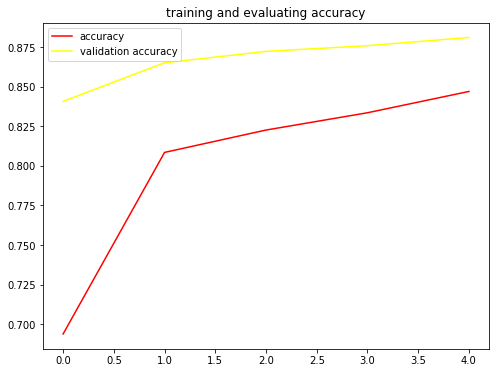

In [ ]:
plot_accuracy_loss_curves(fine_tuning_history)

In [ ]:
model.evaluate(test_data)

79/79 [==============================] - 93s 1s/step - loss: 0.2953 - accuracy: 0.9008


[0.2953108251094818, 0.9007999897003174]

In [ ]:
y_preds = model.predict(test_data)

In [ ]:
result = [tf.argmax(y_preds[i]) for i in range(len(y_preds))]

In [ ]:
result[:10]

[<tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=2>,
 <tf.Tensor: shape=(), dtype=int64, numpy=7>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=6>,
 <tf.Tensor: shape=(), dtype=int64, numpy=6>,
 <tf.Tensor: shape=(), dtype=int64, numpy=6>,
 <tf.Tensor: shape=(), dtype=int64, numpy=9>,
 <tf.Tensor: shape=(), dtype=int64, numpy=6>]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

def get_class_labels_from_directory(directory):
    # Ambil nama subfolder sebagai label
    return sorted([folder for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))])

def predict_image(image_path, class_labels):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    image_array = tf.keras.preprocessing.image.img_to_array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)

    print(hasattr(model, 'class_names'))
    prediction = model.predict(image_array)
    predicted_index = np.argmax(prediction)
    probability = np.max(prediction) * 100
    predicted_label = class_labels[predicted_index]

    # Tampilkan gambar dan hasil prediksi
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_label} ({probability:.2f}%)")
    # plt.title(f"Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()


# model = tf.keras.models.load_model("/content/best_food101_model.h5")

# Cek apakah model memiliki class_names
if hasattr(model, 'class_names'):
    class_labels = model.class_names
else:
    # Jika tidak ada, ambil class labels dari direktori dataset
    class_labels = get_class_labels_from_directory("/content/food101/food-101/train")


predict_image("/content/5cb72ada016b64da8adc7a52.w800.jpg", class_labels)
